<a href="https://colab.research.google.com/github/seoin-cho/SOLUX_summer_data/blob/master/3%2C4%EC%A3%BC%EC%B0%A8_%EC%BA%90%EA%B8%80/%EC%BA%90%EA%B8%80%EC%8B%A4%EC%8A%B5_5(8_15~8_16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
train = pd.read_csv('/content/drive/My Drive/train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [ ]:
test = pd.read_csv('/content/drive/My Drive/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

In [ ]:
# Feature Engineering

In [ ]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [ ]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 16)

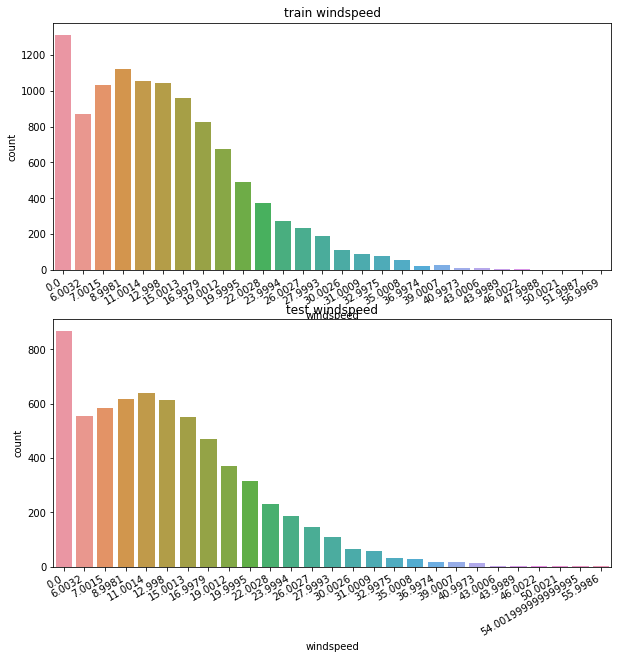

In [ ]:
# windspeed 풍속에 0값이 가장 많다. -> 잘못 기록된 데이터를 고쳐줄 필요가 있음
# 풍속 데이터 시각화 해보기
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(10,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title='test windspeed')
sns.countplot(data=test, x='windspeed', ax=axes[1])

In [ ]:
#풍속의 0값에 특정 값을 넣어준다.
#평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될 것 같진 않다.
#train.loc[train['windspeed']==0, 'windspeed'] = train['windspeed'].mean()

In [ ]:
#풍속이 0인 것과 아닌 것의 세트를 나눠준다.
trainWind0 = train.loc[train['windspeed']==0]
trainWindNot0 = train.loc[train['windspeed']!=0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [ ]:
#머신러닝으로 예측해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
  #풍속이 0인 것과 아닌 것을 나눠준다.
  dataWind0 = data.loc[data['windspeed']==0]
  dataWindNot0 = data.loc[data['windspeed']!=0]

  #풍속을 예측할 피처를 선택한다.
  wCol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']

  #풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
  dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')

  #랜덤포레스트 분류기를 사용한다.
  rfModel_wind = RandomForestClassifier()

  #wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
  rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])

  #학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
  wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

  #값을 다 예측 후 비교해보기 위해 예측한 값을 넣어줄 데이터 프레임을 새로 만든다.
  predictWind0 = dataWind0
  predictWindNot0 = dataWindNot0
  #값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
  predictWind0['windspeed'] = wind0Values

  #dataWindNot0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터 프레임을 합쳐준다.
  data = predictWindNot0.append(predictWind0)

  #풍속의 데이터타입을 float으로 지정해준다.
  data['windspeed'] = data['windspeed'].astype('float')

  data.reset_index(inplace=True)
  data.drop('index', inplace=True, axis=1)

  return data

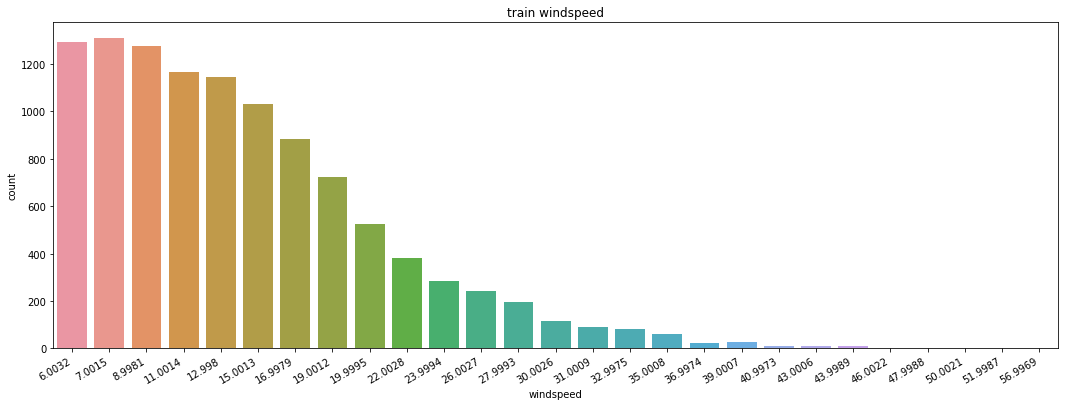

In [ ]:
#0값을 조정한다.
train = predict_windspeed(train)

#windspeed의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')  #글씨가 겹쳐보이는 것을 방지
ax1.set(ylabel='Count', title='train windspeed')
sns.countplot(x='windspeed', data=train, ax=ax1)

In [ ]:
#Feature Selection

In [ ]:
#연속형 feature 와 범주형 feature
#연속형 feature = ['temp', 'humidity', 'windspeed', 'atemp']
#범주형 feature의 type을 category로 변경해준다.
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month','year', 'hour']
for var in categorical_feature_names:
  train[var] = train[var].astype('category')
  test[var] = test[var].astype('category')

In [ ]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'hour', 'dayofweek', 'holiday', 'workingday']
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [ ]:
#행렬 형태로 데이터프레임을 만듦
x_train = train[feature_names]

print(x_train.shape)
x_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [ ]:
#test 행렬을 만듦
x_test = test[feature_names]

print(x_test.shape)
x_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [ ]:
#벡터 형태로 count 데이터프레임을 만듦
#이 값을 바탕으로 test의 count를 예측
label_name = 'count'
y_train = train[label_name]
print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):  #score를 매기는 함수를 만들어준다.
  #넘파이로 배열형태를 바꿔준다.
  predicted_values = np.array(predicted_values)  #array 함수를 이용해 배열형태 변경
  actual_values = np.array(actual_values)

  #예측값과 실제값에 1을 더하고 로그를 취한다.
  log_predict = np.log(predicted_values + 1)  #log함수를 이용해 로그를 취함.
  log_actual = np.log(actual_values + 1)

  #위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
  difference = log_predict - log_actual
  difference = np.square(difference)  #square 함수를 이용해 제곱을 한다.

  #평균을 낸다.
  mean_difference = difference.mean()  #mean 함수를 이용해 평균을 구한다.

  #루트를 씌운다.
  score = np.sqrt(mean_difference)  #sqrt 함수 이용
  
  return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer


make_scorer(rmsle)

In [ ]:
#KFold 방식을 이용한 교차검증
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
#RandomForest
from sklearn.ensemble import RandomForestRegressor
max_depth_list = []
#n_estimators 값은 높을수록 성능이 좋지만 시간이 오래 걸림.
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
%time score = cross_val_score(model, x_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
#score가 0에 근접할수록 좋은 데이터
print('Score={0:.5f}'.format(score))

CPU times: user 3.4 s, sys: 711 ms, total: 4.11 s
Wall time: 30.8 s
Score=0.33102


In [ ]:
#Train
#피처와 레이블을 넣어주면 알아서 학습함.
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
#예측
predictions = model.predict(x_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.47,   5.15,   4.31,   3.44,   3.17,   5.95,  38.07, 107.3 ,
       234.7 , 137.05])

[Text(0.5, 1.0, 'test')]

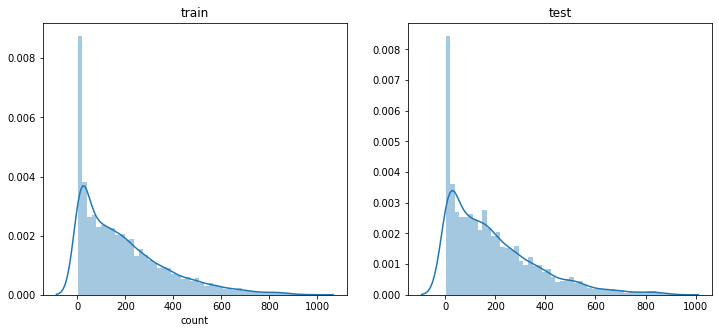

In [ ]:
#예측한 데이터를 시각화해본다.
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')
sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')

In [ ]:
#Submit
submission = pd.read_csv('/content/drive/My Drive/sampleSubmission.csv')
submission

#submission 데이터프레임의 count 열에 예측한 값을 넣어준다.
submission['count'] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.47
1,2011-01-20 01:00:00,5.15
2,2011-01-20 02:00:00,4.31
3,2011-01-20 03:00:00,3.44
4,2011-01-20 04:00:00,3.17


In [ ]:
#submission 파일을 원하는 위치에 저장하고 캐글에 submit
#점수도 함께 적어준다.
submission.to_csv('/content/drive/My Drive/Score_{0:.5f}_submission.csv'.format(score), index=False)

In [ ]:
#점수: 0.41937
#내 등수를 통해 상위 몇 %인지 알아보기
437/3242

0.13479333744602098